# 1. Setting Up

## 1.1 Libraries and Functions

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# evaluate prediction on test set (meter/sec)
def evaluate(model, X_test):
    y_pred = model.predict(X_test)
    res = list(y_pred - y_test)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    print("Number of predictions:", len(y_pred))
    print("MAE:", MAE)
    print("MSE:", MSE)
    print("Mean:", np.mean(res))
    print("Std:", np.std(res))

In [3]:
# evaluate prediction for rf
def evaluate_rf(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('MAPE = {:0.2f}%.'.format(mape), '\n')
    
    return accuracy

In [4]:
# plot prediction result
def plot_res(model, X_test, title, fname):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    ax.scatter(y_test, model.predict(X_test), color='steelblue', alpha=0.3)
    ax.plot([0,10], [0,10], 'indianred', linestyle=':')

    plt.xlabel("Actual Speed (m/s)", fontsize=14)
    plt.ylabel("Predicted Speed (m/s)", fontsize=14)
    plt.title("%s Prediction"%title, fontsize=18)

    plt.savefig("output/%s.png"%fname, dpi=300)
    plt.show()

## 1.2 Data Wrangling

In [5]:
df = pd.read_csv("bus_train.csv", index_col=0)
df.head()

,Timestamp_x,segment_id,BusLane_x,DayOfWeek_x,Holiday_x,HalfHourly,timeinseconds,intersections_x,busstops_x,AvgSpeed
NewVehicleRef,,,,,,,,,,
MTA NYCT_3828_1,2018-04-21 17:32:06.404000-04:00,1,False,6,1,3,63126,11,4,2.297799
MTA NYCT_3828_1,2018-04-27 18:38:40.371000-04:00,1,True,5,0,5,67120,11,4,3.013069
MTA NYCT_3828_1,2018-05-01 17:02:12.294000-04:00,1,True,2,0,2,61332,11,4,2.941267
MTA NYCT_3828_1,2018-04-21 17:37:56.484000-04:00,2,False,6,1,3,63476,15,5,1.005892
MTA NYCT_3828_1,2018-04-27 18:42:20.961000-04:00,2,True,5,0,5,67340,15,5,2.848134


In [6]:
df.columns

Index(['Timestamp_x', 'segment_id', 'BusLane_x', 'DayOfWeek_x', 'Holiday_x',
       'HalfHourly', 'timeinseconds', 'intersections_x', 'busstops_x',
       'AvgSpeed'],
      dtype='object')

In [7]:
# rename columns
df.columns = ['timestamp', 'segment', 'buslane', 'dayofweek', 'holiday',
              'halfhourly', 'timeinseconds', 'intersections', 'busstops', 'avgspeed']
df.shape

(3262, 10)

In [8]:
# number and percentage of records with negative speeds
len(df[df['avgspeed'] < 0]), len(df[df['avgspeed'] < 0]) / len(df) * 100

(8, 0.2452483139178418)

In [9]:
# remove negative speeds
df = df[df['avgspeed'] > 0]
df.shape

(3215, 10)

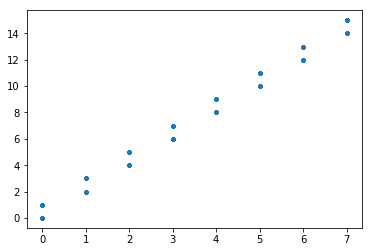

In [10]:
# redo time span partition if needed (or use halfhourly by default)
df['timespan'] = pd.cut(df.timeinseconds, range(57600, 73800, 900), right=False, labels=False)
# visually check if the partition is correct
plt.plot(df['halfhourly'], df['timespan'], '.')

## 1.3 Preparing train and test X-y datasets

In [11]:
# create X and y
X = df[['segment', 'buslane', 'dayofweek', 'holiday',
        'timespan', 'intersections', 'busstops']]
y = df['avgspeed']

X.head()

,segment,buslane,dayofweek,holiday,timespan,intersections,busstops
NewVehicleRef,,,,,,,
MTA NYCT_3828_1,1,False,6,1,6,11,4
MTA NYCT_3828_1,1,True,5,0,10,11,4
MTA NYCT_3828_1,1,True,2,0,4,11,4
MTA NYCT_3828_1,2,False,6,1,6,15,5
MTA NYCT_3828_1,2,True,5,0,10,15,5


In [12]:
# pre-process for better results for neural networks
X_pp = preprocessing.scale(X)

In [13]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2018)
# split dataset (pre-processed)
X_train_pp, X_test_pp, y_train, y_test = train_test_split(X_pp, y, test_size = 0.3, random_state = 2018)

# 2. Random Forest
pre-processing not required

In [17]:
# train model
rf = RandomForestRegressor(max_depth=10, n_estimators=80, n_jobs=-1,
                           max_leaf_nodes=30, random_state=100, oob_score=True)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=30,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
           oob_score=True, random_state=100, verbose=0, warm_start=False)

In [23]:
# out-of-bag score
print("Out-of-bag score estimate: {0}".format(rf.oob_score_))

Out-of-bag score estimate: 0.3034645975047481


In [19]:
R2_IS = rf.score(X_train, y_train)
R2_OS = rf.score(X_test, y_test)

print("R-squared for IS RF is: {0}".format(R2_IS))
print("R-squared for OS RF is: {0}".format(R2_OS))

R-squared for IS OLS is: 0.42538572406065955
R-squared for OS OLS is: 0.27178903196989757


In [24]:
evaluate(rf, X_test)

Number of predictions: 965
MAE: 0.5959944824923039
MSE: 0.7990786603162741
Mean: -0.008996904663790911
Std: 0.8938667216217107


In [25]:
# examine feature importance
print(rf.feature_importances_)

[0.36283247 0.16130697 0.13223295 0.00270628 0.30082466 0.03467669
 0.00541997]


In [26]:
# cross-reference
X.columns

Index(['segment', 'buslane', 'dayofweek', 'holiday', 'timespan',
       'intersections', 'busstops'],
      dtype='object')

In [27]:
# try to predict a random segment
print(rf.predict([[3, 1, 2, 0, 8, 16, 6]]))

[2.03045058]


In [28]:
# predict the same segment on weekend instead
print(rf.predict([[3, 0, 7, 1, 8, 16, 6]]))

[2.76273354]


In [29]:
# tune hyper-parameters using a random search
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 100, 12)]
# Maximum number of
max_leaf_nodes = [int(x) for x in np.linspace(2, 70, 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'max_leaf_nodes': max_leaf_nodes,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#print(random_grid)

In [30]:
# random search with 3-fold cross validation
# search across 100 different combinations with all available cores
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=200, cv=3, verbose=False, random_state=2018, n_jobs=-1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 11, 20, 29, 38, 47, 55, 64, 73, 82, 91, 100], 'max_leaf_nodes': [2, 9, 17, 24, 32, 39, 47, 54, 62, 70], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=2018, refit=True,
          return_train_score=True, scoring=None, verbose=False)

In [31]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 38,
 'max_features': 'sqrt',
 'max_leaf_nodes': 62,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 73}

In [32]:
# evaluate random search performance
base_model = rf
base_model.fit(X_train, y_train)
base_accuracy = evaluate_rf(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate_rf(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.6528 degrees.
Accuracy = 55.78%.
MAPE = 44.22%. 

Model Performance
Average Error: 0.5868 degrees.
Accuracy = 59.85%.
MAPE = 40.15%. 

Improvement of 7.28%.


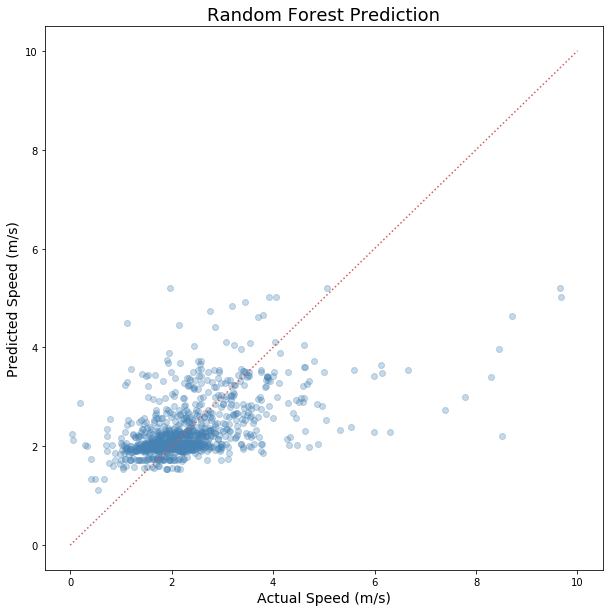

In [33]:
plot_res(best_random, X_test, "Random Forest", "rf")

# 3. Linear Regression

## 3.1 OLS

In [34]:
# smf provides summary
# lm = smf.ols(formula='avgspeed ~ C(segment) + C(buslane) + C(dayofweek) + C(holiday) + C(timespan) + intersections + busstops', data=df).fit()
# lm.summary()

In [35]:
OLS = linear_model.LinearRegression(fit_intercept=True)
OLS.fit(X_train, y_train)

R2_IS = OLS.score(X_train, y_train)
R2_OS = OLS.score(X_test, y_test)

print("R-squared for IS OLS is: {0}".format(R2_IS))
print("R-squared for OS OLS is: {0}".format(R2_OS))

R-squared for IS OLS is: 0.22953681819803917
R-squared for OS OLS is: 0.1876978476105674


In [36]:
evaluate(OLS, X_test)

Number of predictions: 965
MAE: 0.6319376316224261
MSE: 0.8913533909812544
Mean: -0.013611809928611015
Std: 0.9440170070563993


## 3.2 Lasso

In [37]:
lasso_alpha = 0.0001
Lasso = linear_model.Lasso(fit_intercept=True, alpha=lasso_alpha)
Lasso.fit(X_train, y_train)

R2_IS = Lasso.score(X_train, y_train)
R2_OS = Lasso.score(X_test, y_test)

print("R-squared for IS Lasso is: {0}".format(R2_IS))
print("R-squared for OS Lasso is: {0}".format(R2_OS))

R-squared for IS Lasso is: 0.22953659310212693
R-squared for OS Lasso is: 0.18768026019092576


In [38]:
evaluate(Lasso, X_test)

Number of predictions: 965
MAE: 0.6319284032674524
MSE: 0.8913726899651241
Mean: -0.013634929243362476
Std: 0.9440268950986792


## 3.3 Ridge

In [39]:
ridge_alpha = 42
Ridge = linear_model.Ridge(fit_intercept=True, alpha=ridge_alpha)
Ridge.fit(X_train, y_train)

R2_IS = Ridge.score(X_train, y_train)
R2_OS = Ridge.score(X_test, y_test)

print("R-squared for IS Ridge is: {0}".format(R2_IS))
print("R-squared for OS Ridge is: {0}".format(R2_OS))

R-squared for IS Ridge is: 0.22903374569141477
R-squared for OS Ridge is: 0.18843070762886283


In [40]:
# evaluate prediction on test set (meter/sec)
evaluate(Ridge, X_test)

Number of predictions: 965
MAE: 0.6312044573705393
MSE: 0.890549210836587
Mean: -0.014782272694389363
Std: 0.9435733650599595


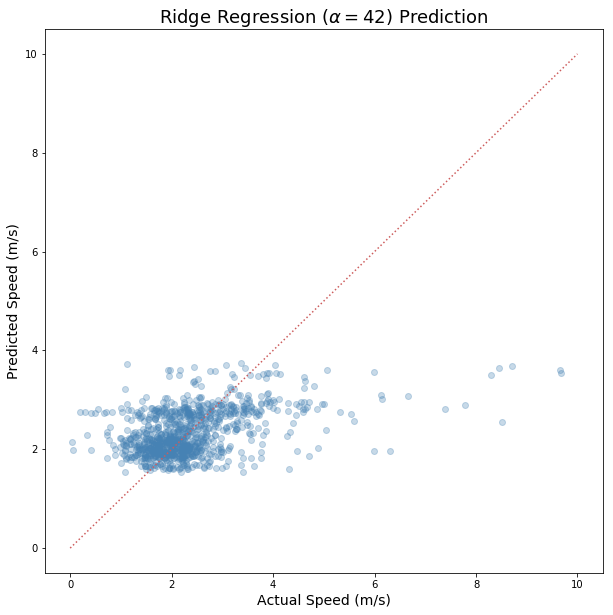

In [41]:
plot_res(Ridge, X_test, "Ridge Regression ($\\alpha=42$)", "ridge")

# 4. Neural Network

In [42]:
nn = MLPRegressor(hidden_layer_sizes=(40,),
                  activation='relu',
                  solver='lbfgs',
                  learning_rate='adaptive',
                  max_iter=1000,
                  learning_rate_init=0.001,
                  alpha=0.01,
                  random_state=1009)
nn.fit(X_train_pp, y_train)

MLPRegressor(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1009,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [43]:
R2_IS = nn.score(X_train_pp, y_train)
R2_OS = nn.score(X_test_pp, y_test)

print("R-squared for IS NN is: {0}".format(R2_IS))
print("R-squared for OS NN is: {0}".format(R2_OS))

R-squared for IS NN is: 0.44067071365354715
R-squared for OS NN is: 0.2516648997777198


In [44]:
evaluate(nn, X_test_pp)

Number of predictions: 965
MAE: 0.6070279481031263
MSE: 0.8211612233345893
Mean: -0.013873136440173503
Std: 0.9060732638257801


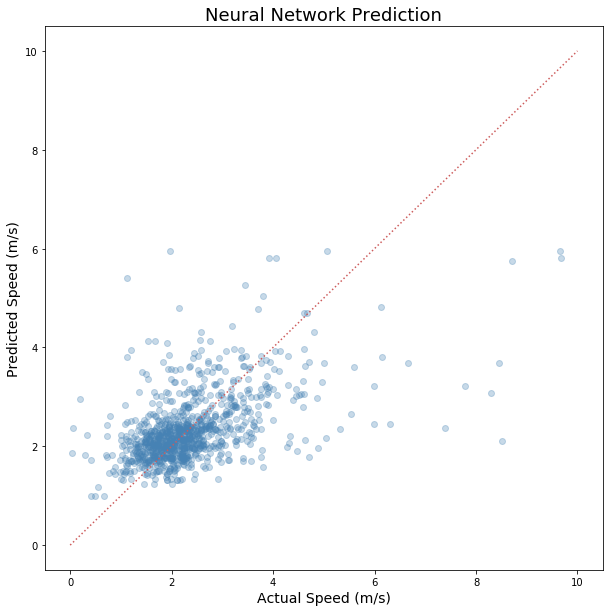

In [45]:
plot_res(nn, X_test_pp, "Neural Network", "nn")

# 5. Comparison

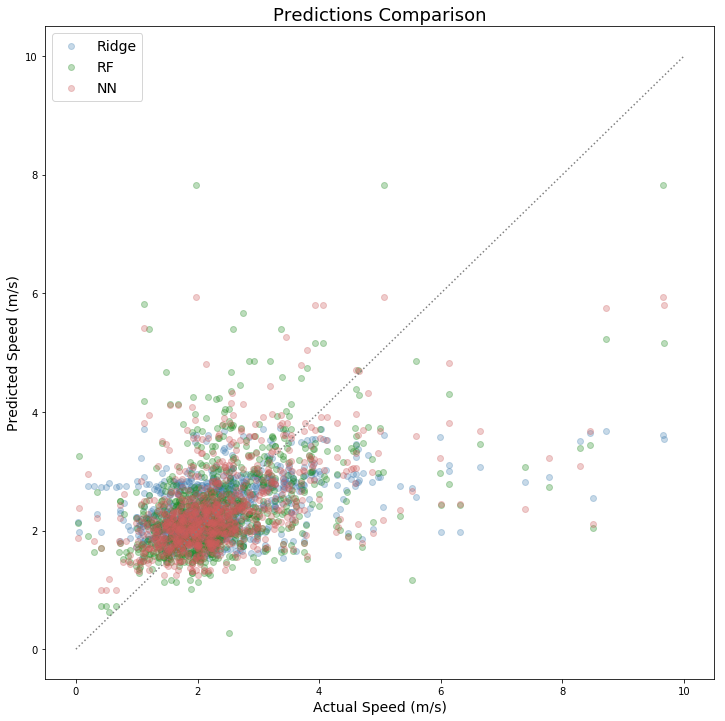

In [46]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.scatter(y_test, Ridge.predict(X_test), color='steelblue', marker='o', alpha=0.3, label='Ridge')
ax.scatter(y_test, rf.predict(X_test), color='forestgreen', marker='o', alpha=0.3, label='RF')
ax.scatter(y_test, nn.predict(X_test_pp), color='indianred', marker='o', alpha=0.3, label='NN')
ax.plot([0,10], [0,10], 'gray', linestyle=':')

plt.xlabel("Actual Speed (m/s)", fontsize=14)
plt.ylabel("Predicted Speed (m/s)", fontsize=14)
plt.title("Predictions Comparison", fontsize=18)
plt.legend(fontsize=14)

plt.savefig("output/all.png", dpi=300)
plt.show()

# 6. Separate NN Models
Below is just a test using the result label (y_test) to demonstrate what a multiple-model prediction looks like reversely. In order to really implement it, we need to train the model based on different input criteria instead. For example, since half of the high-speed outliers happen in segment 1, and most of them are during off-peak (bus lane inactive), maybe a separate model should be trained to predict speeds during off-peak for segment 1, and hopefully, the result will resemble the one demonstrated below.

In [47]:
# evaluate prediction on test set (meter/sec) (with an additional arg for y_test)
def evaluate_nn(model, X_test, y_test):
    y_pred = model.predict(X_test)
    res = list(y_pred - y_test)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    print("Number of predictions:", len(y_pred))
    print("MAE:", MAE)
    print("MSE:", MSE)
    print("Mean:", np.mean(res))
    print("Std:", np.std(res))

In [48]:
# plot prediction result (with an additional arg for y_test)
def plot_res_nn(model, X_test, y_test, title, fname):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    ax.scatter(y_test, model.predict(X_test), color='steelblue', alpha=0.3)
    ax.plot([0,10], [0,10], 'indianred', linestyle=':')

    plt.xlabel("Actual Speed (m/s)", fontsize=14)
    plt.ylabel("Predicted Speed (m/s)", fontsize=14)
    plt.title("%s Prediction"%title, fontsize=18)

    plt.savefig("output/%s.png"%fname, dpi=300)
    plt.show()

In [49]:
# train separate models for different speed range
X_train_pp_1 = X_train_pp[y_train < 6]
X_train_pp_2 = X_train_pp[y_train >= 6]
y_train_1 = y_train[y_train < 6]
y_train_2 = y_train[y_train >= 6]

X_test_pp_1 = X_test_pp[y_test < 6]
X_test_pp_2 = X_test_pp[y_test >= 6]
y_test_1 = y_test[y_test < 6]
y_test_2 = y_test[y_test >= 6]

In [50]:
# train the first one (for those speed < 6)
nn1 = MLPRegressor(hidden_layer_sizes=(40,),
                  activation='relu',
                  solver='lbfgs',
                  learning_rate='adaptive',
                  max_iter=1000,
                  learning_rate_init=0.001,
                  alpha=0.01,
                  random_state=1009)
nn1.fit(X_train_pp_1, y_train_1)

MLPRegressor(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1009,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [51]:
R2_IS = nn1.score(X_train_pp_1, y_train_1)
R2_OS = nn1.score(X_test_pp_1, y_test_1)

print("R-squared for IS NN1 is: {0}".format(R2_IS))
print("R-squared for OS NN1 is: {0}".format(R2_OS))

R-squared for IS NN1 is: 0.4270615902486565
R-squared for OS NN1 is: 0.2156140355827585


In [52]:
evaluate_nn(nn1, X_test_pp_1, y_test_1)

Number of predictions: 953
MAE: 0.5470046314633649
MSE: 0.5589980981732308
Mean: 0.013110675663743809
Std: 0.7475467934229073


In [53]:
# train another one for outlier records
nn2 = MLPRegressor(hidden_layer_sizes=(10,),
                  activation='relu',
                  solver='lbfgs',
                  learning_rate='adaptive',
                  max_iter=1000,
                  learning_rate_init=0.25,
                  alpha=1.8,
                  random_state=1009)
nn2.fit(X_train_pp_2, y_train_2)

MLPRegressor(activation='relu', alpha=1.8, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='adaptive',
       learning_rate_init=0.25, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1009,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [54]:
R2_IS = nn2.score(X_train_pp_2, y_train_2)
R2_OS = nn2.score(X_test_pp_2, y_test_2)

print("R-squared for IS NN2 is: {0}".format(R2_IS))
print("R-squared for OS NN2 is: {0}".format(R2_OS))

R-squared for IS NN2 is: 0.4236248034846063
R-squared for OS NN2 is: 0.3891873904032245


In [55]:
evaluate_nn(nn2, X_test_pp_2, y_test_2)

Number of predictions: 12
MAE: 0.835740240594392
MSE: 0.9245187867082177
Mean: -0.18000363923279897
Std: 0.9445197068199087


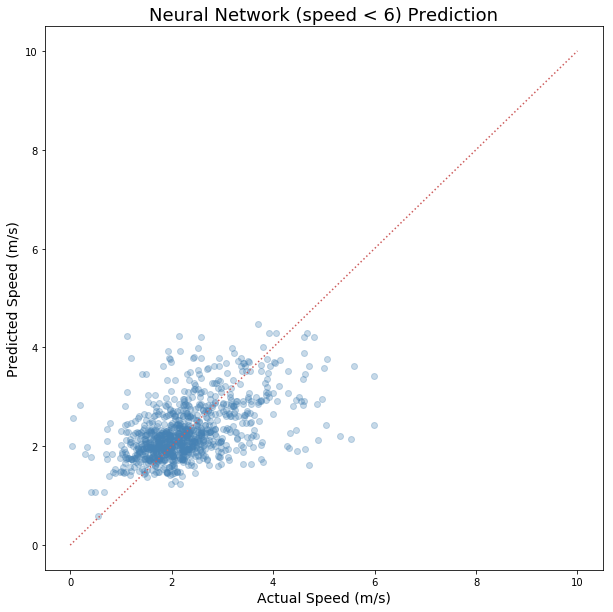

In [56]:
plot_res_nn(nn1, X_test_pp_1, y_test_1, "Neural Network (speed < 6)", "nn1")

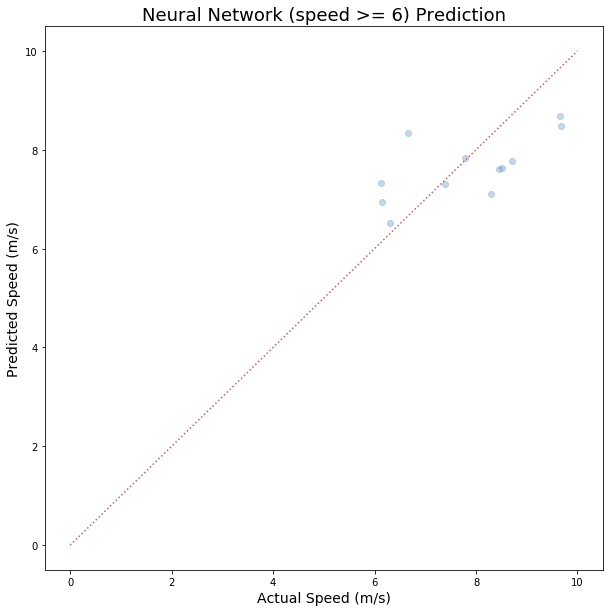

In [57]:
plot_res_nn(nn2, X_test_pp_2, y_test_2, "Neural Network (speed >= 6)", "nn2")

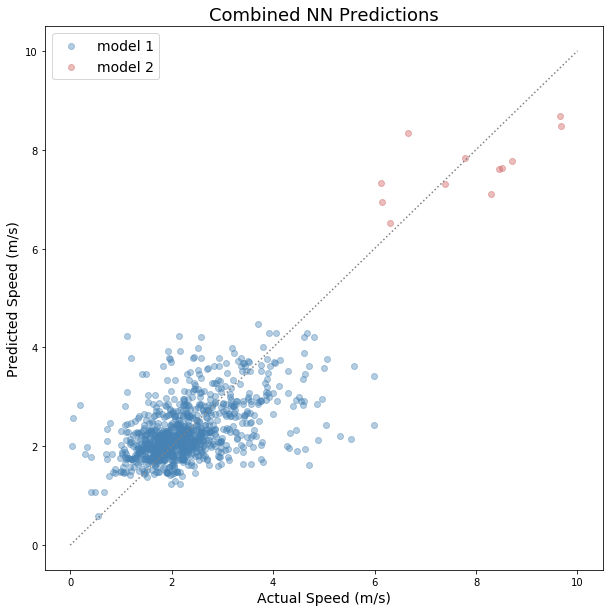

In [58]:
# plot prediction result of combined NN models

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.scatter(y_test_1, nn1.predict(X_test_pp_1), color='steelblue', alpha=0.4, label='model 1')
ax.scatter(y_test_2, nn2.predict(X_test_pp_2), color='indianred', alpha=0.4, label='model 2')
ax.plot([0,10], [0,10], 'gray', linestyle=':')

plt.xlabel("Actual Speed (m/s)", fontsize=14)
plt.ylabel("Predicted Speed (m/s)", fontsize=14)
plt.title("Combined NN Predictions", fontsize=18)
plt.legend(fontsize=14)

plt.savefig("output/nncombined.png", dpi=300)
plt.show()

# 7. A quick look into outliers

In [59]:
print("Number of high-speed outliers:", len(df[df['avgspeed'] >= 6.14]))
df[(df['avgspeed'] >= 6.14)]

Number of high-speed outliers: 24


,timestamp,segment,buslane,dayofweek,holiday,halfhourly,timeinseconds,intersections,busstops,avgspeed,timespan
NewVehicleRef,,,,,,,,,,,
MTA NYCT_3830_1,2018-05-01 19:25:52.229000-04:00,5,False,2,0,6,69952,8,3,7.344242,13
MTA NYCT_3831_1,2018-04-21 18:11:01.023000-04:00,1,False,6,1,4,65461,11,4,8.290215,8
MTA NYCT_3833_1,2018-04-21 17:00:25-04:00,5,False,6,1,2,61225,8,3,6.897419,4
MTA NYCT_3881_1,2018-04-10 19:39:23-04:00,1,False,2,0,7,70763,11,4,8.420421,14
MTA NYCT_3881_1,2018-04-21 16:43:45-04:00,5,False,6,1,1,60225,8,3,9.260312,2
MTA NYCT_3883_2,2018-04-09 19:41:02-04:00,1,False,1,0,7,70862,11,4,9.647302,14
MTA NYCT_3885_1,2018-05-01 16:00:23-04:00,5,True,2,0,0,57623,8,3,6.310625,0
MTA NYCT_3886_1,2018-04-09 18:23:09-04:00,1,True,1,0,4,66189,11,4,6.650089,9
MTA NYCT_3886_2,2018-04-08 19:32:02-04:00,1,False,7,1,7,70322,11,4,8.383016,14


In [60]:
# number of outliers took place on segment 1 when bus lane is inactive
len(df[(df['avgspeed'] >= 6.14) * (df['segment'] == 1) * (df['buslane'] == False)])

/Users/Yuwen/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


13

In [61]:
# number of records took place on segment 1 when bus lane is inactive
len(df[(df['segment'] == 1) * (df['buslane'] == False)])

/Users/Yuwen/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


149